Dans ce notebook, nous allons appliquer l'algortihme de Descente du gradient stochastique distribué sur le jeu de données  "movielens" décrit ci-dessous, en utilisant la librairie pyspark pour le calcul distribué.

# Description des données :

Toutes les notes d'évaluation du fichier "u.dat" sont sous la forme suivante :

UserID, MovieID, Rating, Timestamp

- UserIDs compris entre 1 et 943
- MovieIDs est compris 1 et 1682
- Ratings est compris entre 1 et 5 (1 pour un note faible et 5 pour une note élevée)
- Timestamp 

## Import des librairies

In [1]:
# import des librairies
import sys
import numpy as np
from scipy import sparse
from pyspark import SparkContext, SparkConf
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Déclaration des variables et initialisatiion de SC 

In [2]:
# Déclaration des variables
inputV_filepath = "/home/tux/Downloads/u.data"  # Fichier d'import de la matrice V
num_users = 0
num_movies=0
clock=0         
clk=0           
num_workers = 20     # nombre de threads

# Initialisatiion de SC 
conf = SparkConf().setAppName('DSGD').setMaster('local[%d]' % num_workers)
sc = SparkContext(conf=conf)

## Création des matrices V, H, W

In [3]:
# Création de la matrice pour les films H et la matrice pour les utisateurs W
def CreateMatrixHW(num_factors) :
    """ Cette fonction parcourt le fichier d'input "inputV_filepath" afin de récuperer la valeur maximum 
    de l'identifiant utilisateur (max_user)  et la valeur maximum de l'identifiant des films (max_movie).
    Puis, on crée deux matrices remplies aléatoirement :
    W de dimension max_user x num_factors et H de dimension num_factors x max_movie.
    """
    with open(inputV_filepath, 'r') as f_in :
        max_user = 0   # on initialise max_user
        max_movie = 0  # on initialise max_movie
        for line in f_in :  # on parcourt le fichier input
            line = line.rstrip()  # renvoie une copie de la chaine avec les caractères finaux supprimés
            eachline = line.split(",")  # renvoie les termes de la chaines séparés par une virgule
            for i in range(3) :
                eachline[i] = int(eachline[i])
            if max_user < eachline[0] :    # on recupère le userID le plus grand
                max_user = eachline[0]
            if max_movie < eachline[1] :   # on recupère le MovieID le plus grand
                max_movie = eachline[1]
    W = np.matrix(np.random.rand(max_user, num_factors)) # Matrice des utilisateurs
    H = np.matrix(np.random.rand(num_factors,max_movie)) # Matrice des films
    return W, H

# Création de la matrice de notation V de dimension nombre d'utilisateurs x nombre de films 
def CreateMatrixV(num_users, num_movies) :
    ''' cette fonction initialise une matrice de dimension num_users x num_movies, puis elle parcourt le fichier 
    d'input "inputV_filepath" afin de remplir la matrice V.
    '''
    with open(inputV_filepath, 'r') as f_in :
        V = sparse.lil_matrix((num_users, num_movies))  # permet de construire une structure matrice
        for line in f_in :      # on parcours le fichier input
            line = line.rstrip()     # renvoie une copie de la chaine avec les caractères finaux supprimés
            eachline = line.split(",")   # renvoie les termes de la chaines séparés par une virgule
            for i in range(3) :
                eachline[i] = int(eachline[i])     # on met UserID dans la colonne 1, MovieID dans la colonne 2 ...
            V[eachline[0] -1, eachline[1] -1] = eachline[2]   # on remplit la matrice avec rating
    return V

## Calcul du gradient 

In [4]:
# Calcul du gradient sur les "num_workers" blocks par "num_workers" threads en parallèle.
def CalcGradient(block_tuple) :
    ''' L'objectif de cette fonction est de compléter le block pour la matrice H et celui pour la matrice W.
    On a les blocks pour la matrice H et W qui ont été remplis aléatoirement au préalable et le block pour 
    la matrice V qui contient les vraies valeurs des ratings. Nous allons calculer la différence entre le block de 
    la matrice V et le produit des blocks des matrices H et W, puis essayer de minimiser itérativement cette 
    différence. Il s'agit de la méthode de la descente en gradient.
    '''
    V_block = block_tuple[0]
    W_block = block_tuple[1]
    H_block = block_tuple[2]
    c = 0
    rows, cols = V_block.nonzero() # indices des éléments non nuls
    for i, j in zip(rows, cols) :
        tmp = V_block[i,j] - (W_block[i, :] * H_block[:, j])[0, 0]  # différence entre vraies valeurs et valeurs prédites
        eta = pow(100 + clk + c, -beta_value)   # pas d'apprentissage
        new_W_block = W_block[i, :] - eta * \
                    (-2 * tmp * H_block[:, j].transpose() \
                    + 2 * lambda_value * W_block[i, :] / V_block.tocsr()[i, :].nnz) # mise à jour de W
        H_block[:, j] = H_block[:, j] - eta * \
                    (-2 * tmp * W_block[i, :].transpose() \
                    + 2 * lambda_value * H_block[:, j] / V_block.tocsc()[:, j].nnz) # mise à jour de H
        W_block[i, :] = new_W_block.copy()
        c += 1       # permet de diminuer le pas au sein de la boucle for
    clock.add(len(rows))
    return (W_block, H_block)

## Incrémentation des règles

In [5]:
# Passage à la regle suivante
def NextStrata(strata) :
    strata[1] = (strata[1] + 1) % num_workers
    return strata

## Indices des lignes et des colonnes

In [6]:
# Récupération des numéros de lignes et des colonnes pour chaque block
def GetRowCol(strata):
    rows = [i for i in range(strata[0], num_users, num_workers)]
    cols = [j for j in range(strata[1], num_movies, num_workers)]
    return (rows, cols)

## Calcul du MSE

In [7]:
# Calcul du MSE
def CalceError(V, W, H):
    """ On calcule l'erreur quadratique moyenne entre les valeurs de la matrice V et le produit de la matrice W*H
    """
    error = 0.0
    V_err= W * H
    rows, cols = V.nonzero()
    for i, j in zip(rows,cols):
        tmp = V[i,j] - V_err[i,j]
        error += tmp * tmp
    error /= len(rows)
    return error

## Recherche du nombre d'itérations optimal

In [8]:
# fonction qui permet de déterminer le nombre d'iterations optimal
def test_iter_opt(num_factors=20, num_workers=10, num_iterations=50, beta_value=0.5, lambda_value=0.0002):

    # Variables globales
    global clock
    global num_users
    global num_movies
    global clk
    
    #Création de W, H et V
    W, H = CreateMatrixHW(num_factors)
    num_users = W.shape[0]
    num_movies = H.shape[1]
    V = CreateMatrixV(num_users,num_movies)
    MSE= np.empty((0))

    # Initialisation de la règle
    init_strata = [[i, v] for i, v in enumerate(np.random.permutation(num_workers))]
    S = sc.parallelize(init_strata)   # parallèlisation des blocks
    
    # Initialisation de la variable clock
    clock=sc.accumulator(0)

    # Exécution du SGD en parallèle
    for i in range(num_iterations) :
        
        # Lignes et colones des blocs en parallèle
        split = S.map(GetRowCol).collect()
        
        # Recuperation des blocs 
        matrices = []
        for row, col in split :
            V_block = V.tocsr()[row, ].tocsc()[:, col] 
            W_block = W[row, ].copy()
            H_block = H[:, col].copy()
            matrices.append((V_block, W_block, H_block))
            
        # Récupération de la valeur de la variable clock
        clk = clock.value
        # Calcul du gradient en parallèle
        matrices = sc.parallelize(matrices).map(CalcGradient).collect()
        # Mise à jour de W et H
        for (row, col), (new_W, new_H) in zip(split, matrices) :
            W[row, ] = new_W
            H[:, col] = new_H
        MSE= np.append(MSE,CalceError(V, W, H))
        if (i>=1)&((MSE[i-1] - MSE[i])< 0.001) : # Si la différence entre le MSE actuel et le précedent est plus petite que 0.02, on arrete les iterrations            
            break        
        # Règle suivante
        S = S.map(NextStrata)
        # Affichage des paramètres
    print('num_factors  =', num_factors)
    print('num_workers  =', num_workers)
    print('num_iterations  =', num_iterations)
    print('beta_value  =', beta_value)
    print('lambda_value  =', lambda_value)
    print ('MSE: %f\n' % CalceError(V, W, H))

    return MSE

## Recherche de paramètres optimaux

In [9]:
# fonction qui permet de déterminer les paramètres optimaux (nombre de facteurs, lambda et béta)
def test_param_opt(num_factors, num_workers, num_iterations, beta_value, lambda_value):
    
    global clock
    global num_users
    global num_movies
    global clk
    # Création de W, H, et V
    W, H = CreateMatrixHW(num_factors)
    num_users = W.shape[0]
    num_movies = H.shape[1]
    V = CreateMatrixV(num_users,num_movies)

    #Initialisation de la règle
    init_strata = [[i, v] for i, v in enumerate(np.random.permutation(num_workers))]
    S = sc.parallelize(init_strata)  # parallèlisation des blocks

    # Initialisation de la variable clock
    clock = sc.accumulator(0)

    # Exécution du SGD en parallèle
    for i in range(num_iterations) :
        
        # Lignes et colones des blocs en parallèle
        split = S.map(GetRowCol).collect()
        
        # Recuperation des blocs 
        matrices = []
        for row, col in split :
            V_block = V.tocsr()[row, ].tocsc()[:, col]
            W_block = W[row, ].copy()
            H_block = H[:, col].copy()
            matrices.append((V_block, W_block, H_block))
            
        # Récupération de la valeur de la variable clock
        clk = clock.value
        # Calcul du gradient en parallèle
        matrices = sc.parallelize(matrices).map(CalcGradient).collect()
        # Mise à jour de W et H
        for (row, col), (new_W, new_H) in zip(split, matrices) :
            W[row, ] = new_W
            H[:, col] = new_H
        # Règle suivante
        S = S.map(NextStrata)

    # Affichage des paramètres
    print('num_factors  =', num_factors)
    print('num_workers  =', num_workers)
    print('num_iterations  =', num_iterations)
    print('beta_value  =', beta_value)
    print('lambda_value  =', lambda_value)
    print ('MSE: %f\n' % CalceError(V, W, H))
    
    return CalceError(V, W, H)

num_factors  = 20
num_workers  = 20
num_iterations  = 50
beta_value  = 0.5
lambda_value  = 0.0002
MSE: 0.880292

le nombre d'iterations qui minimise l'erreur 41


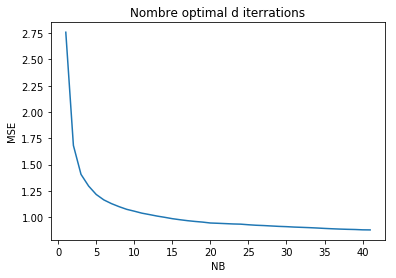

In [10]:
#Recherche du nombre optimal d'iterations
num_factors=20
num_workers=20
num_iterations=50
beta_value=0.5
lambda_value=0.0002
MSE=test_iter_opt(num_factors, num_workers, num_iterations, beta_value, lambda_value)
num_iter_opt= int(np.where(MSE==min(MSE))[0]) + 1
print("le nombre d'iterations qui minimise l'erreur",num_iter_opt)

#graphique recherche du nombre optimal de facteurs
plt.plot(range(1,len(MSE)+1),MSE)
plt.xlabel('NB')
plt.ylabel('MSE')
plt.title('Nombre optimal d iterrations')
plt.show()

10
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.5
lambda_value  = 0.1
MSE: 0.923162

15
num_factors  = 15
num_workers  = 20
num_iterations  = 41
beta_value  = 0.5
lambda_value  = 0.1
MSE: 0.936438

20
num_factors  = 20
num_workers  = 20
num_iterations  = 41
beta_value  = 0.5
lambda_value  = 0.1
MSE: 0.993710

25
num_factors  = 25
num_workers  = 20
num_iterations  = 41
beta_value  = 0.5
lambda_value  = 0.1
MSE: 1.088701



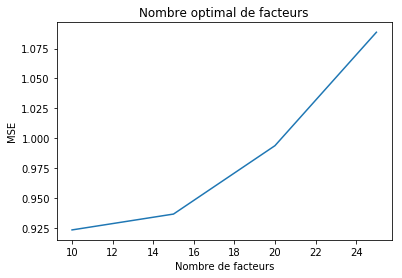

Nb factors qui minimise l'erreur 10


In [20]:
#Recherche du nombre optimal de facteurs
list_factors =range(10,30, 5)#valeurs pour recherche nb factors
e = np.empty((0))
for num_factors in list_factors:
    print(num_factors)
    err = test_param_opt(num_factors, 20, num_iter_opt,0.5,0.1)
    e =np.append(e, err)
ind = np.argmin(e) #indice MSE plus petit  

#graphique du recherche nombre optimal de facteurs
plt.plot(list_factors, e)
plt.ylabel('MSE')
plt.xlabel('Nombre de facteurs')
plt.title('Nombre optimal de facteurs')
plt.show()

best_factor = list_factors[ind]#nombre de facteurs correspondant au MSE plus petit
print("Nb factors qui minimise l'erreur", best_factor)

0.5
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.5
lambda_value  = 0.1
MSE: 0.922434

0.6
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.6
lambda_value  = 0.1
MSE: 0.921456

0.7
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.7
lambda_value  = 0.1
MSE: 0.926705

0.8
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.8
lambda_value  = 0.1
MSE: 0.924904

0.9
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.9
lambda_value  = 0.1
MSE: 0.927010



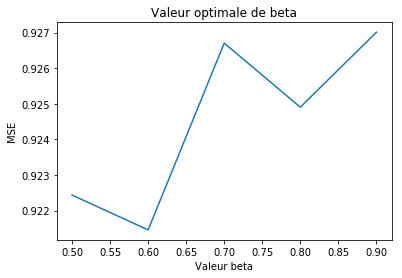

Valeur beta qui minimise l'erreur 0.6


In [22]:
#Recherche de la valeur optimale de beta
list_beta = [0.5,0.6,0.7,0.8,0.9]
e = np.empty((0))
for b in list_beta:
    print(b)
    err = test_param_opt(best_factor,num_workers,num_iter_opt, b, 0.1)
    e = np.append(e, err)
ind = np.argmin(e) #indice MSE plus petit   

#graphique recherche valeur optimale de beta
plt.plot(list_beta, e)
plt.ylabel('MSE')
plt.xlabel('Valeur beta')
plt.title('Valeur optimale de beta')
plt.show()
 
best_beta = list_beta[ind]#valeur beta correspondant au MSE plus petit   
print("Valeur beta qui minimise l'erreur", best_beta)

0.001
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.6
lambda_value  = 0.001
MSE: 0.921719

0.01
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.6
lambda_value  = 0.01
MSE: 0.932376

0.1
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.6
lambda_value  = 0.1
MSE: 0.918878

0.2
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.6
lambda_value  = 0.2
MSE: 0.926314

0.3
num_factors  = 10
num_workers  = 20
num_iterations  = 41
beta_value  = 0.6
lambda_value  = 0.3
MSE: 0.922982



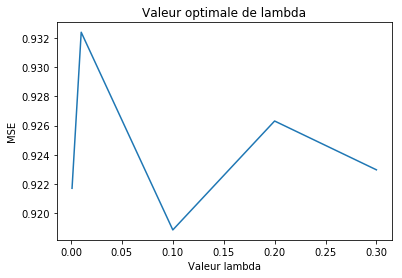

Valeur lambda qui minimise l'erreur 0.1


In [24]:
list_lambda =[0.001,0.01,0.1,0.2,0.3]
e = np.empty((0))
for l in list_lambda:
    print(l)
    err = test_param_opt(best_factor, num_workers, num_iter_opt, best_beta, l)
    e = np.append(e, err)
ind = np.argmin(e) #indice MSE plus petit

#graphique recherche valeur optimale de lambda
plt.plot(list_lambda, e)
plt.ylabel('MSE')
plt.xlabel('Valeur lambda')
plt.title('Valeur optimale de lambda')
plt.show()
best_lambda = list_lambda[ind]#valeur lambda correspondant au MSE plus petit
print("Valeur lambda qui minimise l'erreur", best_lambda)

## DSGD avec les paramètres optimaux

In [25]:
# Parametres optimaux
num_factors = best_factor   
num_workers = 20
num_iterations = num_iter_opt  
lambda_value = best_lambda   
beta_value = best_beta  

# Création de W, H, et V
W, H = CreateMatrixHW(num_factors)
num_users = W.shape[0]
num_movies = H.shape[1]
V = CreateMatrixV(num_users,num_movies)

# Initialisation de la variable clock
init_strata = [[i, v] for i, v in enumerate(np.random.permutation(num_workers))]
S = sc.parallelize(init_strata)    # parallèlisation des blocks

# Initialisation de la variable clock  
clock = sc.accumulator(0)

# Exécution du SGD en parallèle
for i in range(num_iterations) :
    
    # Lignes et colones des blocs en parallèle
    split = S.map(GetRowCol).collect()
    
    # Recuperation des blocs
    matrices = []
    for row, col in split :
        V_block = V.tocsr()[row, :].tocsc()[:, col]
        W_block = W[row, :].copy()
        H_block = H[:, col].copy()
        matrices.append((V_block, W_block, H_block))
        
    #  Récupération de la valeur de la variable clock
    clk = clock.value
    
    # Calcul du gradient en parallèle
    matrices = sc.parallelize(matrices).map(CalcGradient).collect()
    
    #  Mise à jour de W et H
    for (row, col), (new_W, new_H) in zip(split, matrices) :
        W[row, :] = new_W
        H[:, col] = new_H
    # Règle suivante
    S = S.map(NextStrata)


# Calcul du MSE
print ('MSE: %f\n' % CalceError(V, W, H))

MSE: 0.921665



## Valeurs prédites

In [26]:
# Calcul de la nouvelle matrice V
new_V=sparse.lil_matrix(W*H)
# Représentation des coordonnées de new_V
coo = new_V.tocoo(copy=False)
# Création du dataframe
df=pd.DataFrame({'ID_users': coo.row, 'ID_movies': coo.col, 'ratings': coo.data})[['ID_users', 'ID_movies', 'ratings']].reset_index(drop=True)
df['ID_users']=df['ID_users']+1
df['ID_movies']=df['ID_movies']+1
df.head()

,ID_users,ID_movies,ratings
0,1,1,4.126864
1,1,2,3.289309
2,1,3,2.877197
3,1,4,3.848120
4,1,5,3.476026


In [27]:
df['ratings'] = df.ratings.astype(int)
#On se debarasse des valeurs aberrantes
a=[-1,-2,0]
b=[6,7,8,9,10]
for i in a:
    df.ratings[df.ratings==i]=1
for i in b:
    df.ratings[df.ratings==i]=5
df.head()

,ID_users,ID_movies,ratings
0,1,1,4
1,1,2,3
2,1,3,2
3,1,4,3
4,1,5,3


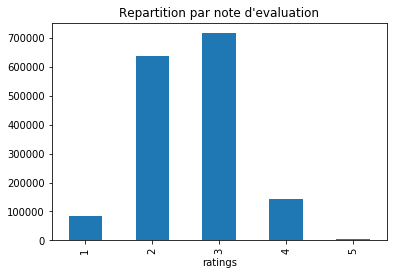

In [29]:
# Répartition des ratings prédites
df.groupby('ratings')['ID_users'].count()
df.groupby('ratings')['ID_users'].count().plot(kind='bar',title="Repartition par note d'evaluation")

In [30]:
df.groupby('ratings')['ID_users'].count()

ratings
1     85695
2    635955
3    715319
4    144222
5      4935
Name: ID_users, dtype: int64